# 📊 Projeto de Previsão de Churn - Telecom
**Disciplina:** Redes Neurais | **Aluno:** Douglas Carvalho

---

### 🎯 Objetivo
Desenvolver e avaliar um classificador baseado em **Stochastic Transformer (STab)** para prever o cancelamento de clientes (Churn), focando em estabilidade e robustez em dados tabulares.

### 🛠 Metodologia
Seguindo as diretrizes do projeto, a abordagem consiste em:
1.  **Setup do Ambiente:** Configuração e carregamento dos dados processados.
2.  **Modelagem STab:** Utilização de arquitetura Transformer estocástica.
3.  **Avaliação:** Métricas completas (KS, AUROC, F1) e validação de estabilidade.
4.  **Registro:** Salvamento automático de logs e gráficos de performance.

# ==========================================
# 0. Imports & Instalação
# ==========================================

In [44]:
%%capture
!pip install -q xgboost pykan

import sys
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import kagglehub
import shutil
import json

# Configuração de Plots
plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# 1. Setup do Ambiente
# ==========================================

In [45]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Adicionar diretório atual ao path para importações funcionarem

In [46]:
import sys
import os

sys.path.append('.')

Correção para Auto-Reload no Python 3.12 (Google Colab)

In [47]:
import importlib

if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ==========================================
# 2. Github
# ==========================================

In [73]:
# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/tabpfn-stab-tabkan_final

Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 283 (delta 36), reused 43 (delta 18), pack-reused 206 (from 1)
Receiving objects: 100% (283/283), 7.07 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/telecom-churn-project/telecom-churn-project/telecom-churn-project
Branch 'feature/tabpfn-stab-tabkan_final' set up to track remote branch 'feature/tabpfn-stab-tabkan_final' from 'origin'.
Switched to a new branch 'feature/tabpfn-stab-tabkan_final'


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:

# 1. Baixa as informações mais recentes do GitHub (sem tentar mesclar ainda)
!git fetch --all

# 2. Reseta o estado atual do Colab para ficar IDÊNTICO ao do GitHub
# !git reset --hard origin/feature/tabpfn-stab-tabkan_final

Fetching origin


Importar as ferramentas para resultados

In [50]:
from src.utils import ensure_directories, get_timestamped_path, log_experiment

ensure_directories()
print("✅ Diretórios de resultados verificados/criados.")

✅ Diretórios de resultados verificados/criados.


Caso você receba um erro de autenticação ao tentar o `git push`, pode ser necessário configurar suas credenciais do Git no Colab. Geralmente, o Colab pedirá para você fazer login no GitHub ou usar um Personal Access Token (PAT). Para mais informações sobre como configurar o PAT, você pode consultar a documentação do GitHub.

# ==========================================
# 3. Dados
# ==========================================

In [51]:
print("⬇️ Baixando dataset do Kaggle...")
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"

dest_path = os.path.join(dest_dir, dest_file)

os.makedirs(dest_dir, exist_ok=True)

source_file = os.path.join(path, "customer_churn_telecom_services.csv")

if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...
📂 Dataset baixado em: /kaggle/input/customers-churned-in-telecom-services
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


Executar Pipeline de Dados

In [52]:
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [53]:

from models.stab_model import STabModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


🚀 Treinando STabModel (tuned + debug)...
========== STabModel INIT ==========
Device: cpu
Config efetivo:
  d_model=64, depth=4, n_heads=4, ff_mult=4
  ff_dropout=0.2, attn_dropout=0.1 (nota: não separado no layer)
  lr=0.0003, weight_decay=0.0, pooling=mean
  batch_size=256, epochs=40, max_fail=10

[build] input_dim registrado = 30
========== TRAIN START ==========
epochs=40, batch_size=256, max_fail=10
n_train=5162, n_val=2580
X_train dtype=torch.float32, y_train dtype=torch.float32
X_val device=cpu, y_val device=cpu
num_batches/epoch=21

[epoch 1] batch 1 shapes:
  xb: (256, 30)  yb: (256,)
  xb.unsqueeze(-1): (256, 30, 1)
  feature_embed: (256, 30, 64)
  transformer out: (256, 30, 64)
  pooling 'mean': (256, 64)
  logits: (256,)
[epoch 1][batch 10/21] loss=0.671601 lr=0.0003
[epoch 1][batch 20/21] loss=0.642768 lr=0.0003
[epoch 1/40] train_loss=0.674196 val_loss=0.653820 best_val=0.653820 fails=0/10 lr=0.0003 time=21.3s
[epoch 2] batch 1 shapes:
  xb: (256, 30)  yb: (256,)
  xb.uns

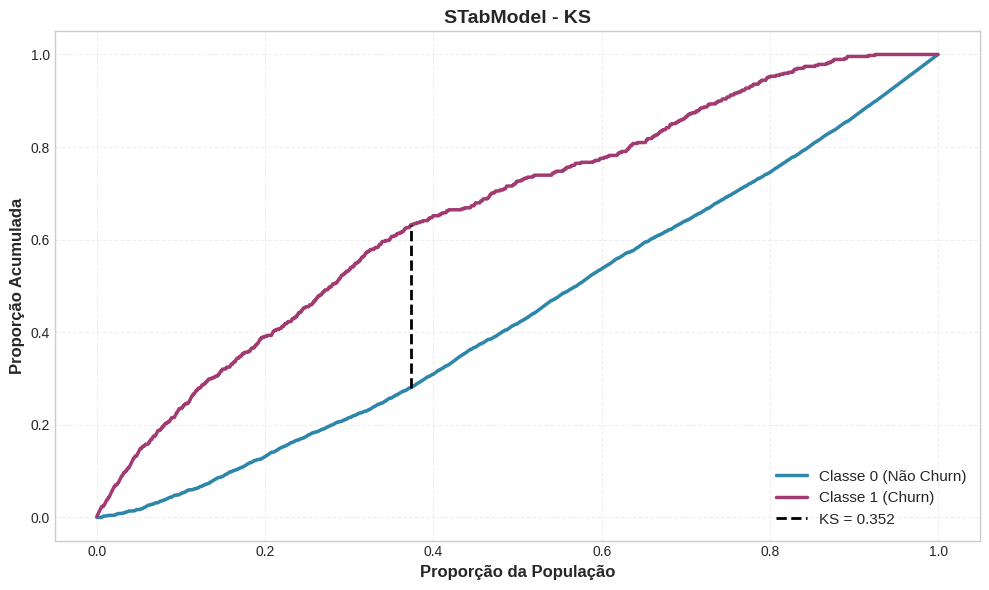

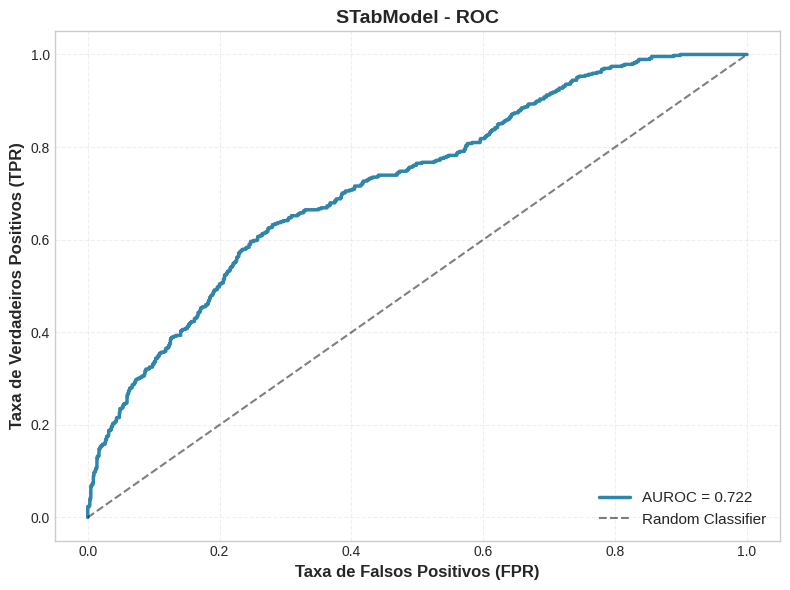

In [54]:
print("🚀 Treinando STabModel (tuned + debug)...")

stab_config = {
    "d_model": 64,
    "depth": 4,
    "n_heads": 4,
    "ff_mult": 4,
    "ff_dropout": 0.2,
    "lr": 3e-4,
    "batch_size": 256,
    "epochs": 40,
    "max_fail": 10,
    "pooling": "mean",

    # DEBUG
    "verbose": True,
    "log_every": 10,        # print a cada 10 batches
    "debug_shapes": True,   # imprime shapes internos (1º batch por época)
    "debug_grads": False    # ativa norma do gradiente (deixa False pra não poluir/atrasar)
}

stab = STabModel(config=stab_config)
stab.build(input_dim=X_train.shape[1])

stab.train(X_train, y_train, X_val, y_val)

y_pred_stab = stab.predict_proba(X_test)
metrics_stab = calculate_all_metrics(y_test, y_pred_stab)

print_metrics("STabModel (Teste)", metrics_stab)
plot_ks_statistic(y_test, y_pred_stab, title="STabModel - KS")
plot_roc_curve(y_test, y_pred_stab, title="STabModel - ROC")


📊 Calculando métricas finais...

🏆 RESULTADOS FINAIS (Teste):
   KS:       0.3523
   AUROC:    0.7223
   F1 Score: 0.5138
📊 Dashboard salvo em: results/figures/dashboard_final_stab_20260110_193730.png


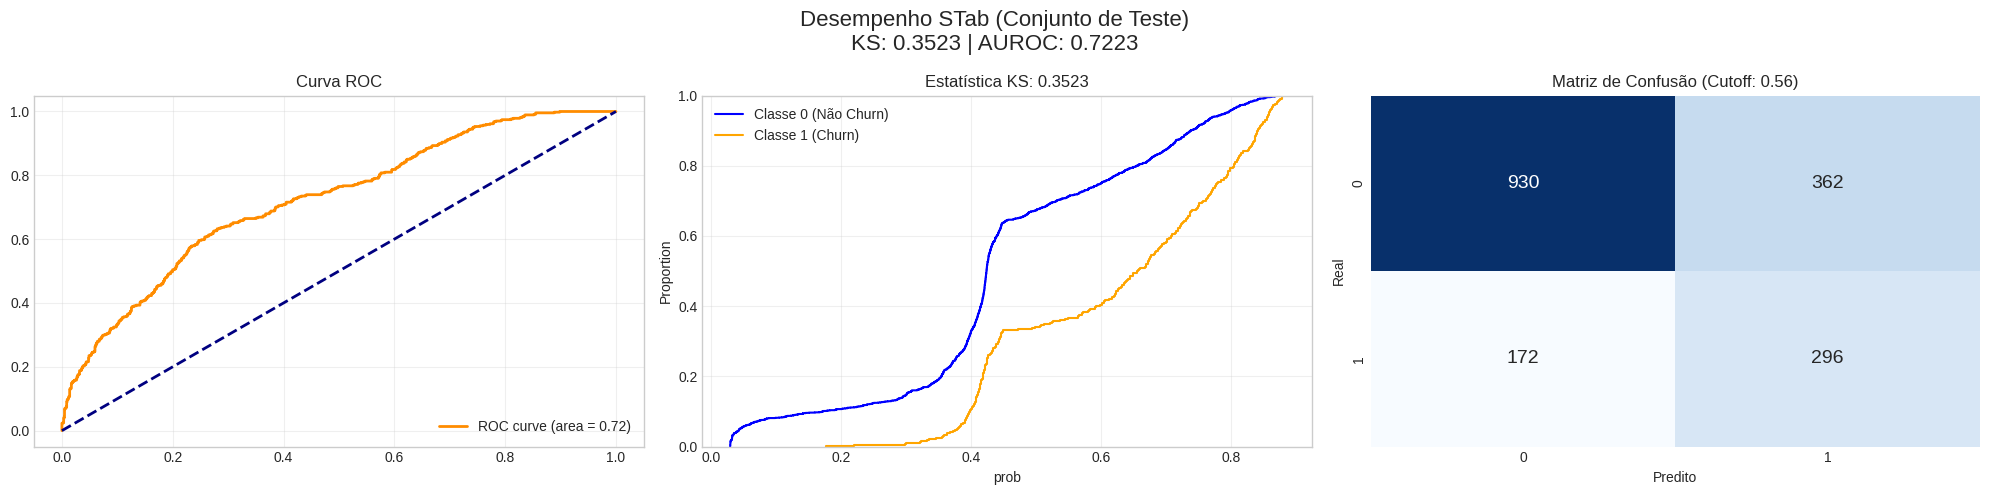

📈 Gráfico KS salvo em: results/figures/stab_ks_20260110_193731.png
📈 Curva ROC salva em: results/figures/stab_roc_20260110_193732.png
📝 Metadados (JSON) salvos em: results/metrics/stab_meta_20260110_193732.json
💾 Modelo salvo em: results/models/stab_model_final_20260110_193732.pth
✅ Experimento registrado no CSV log.


In [ ]:
import json
import torch
import joblib
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ==============================================================================
# 5. Avaliação e Salvamento
# ==============================================================================

# 1. Previsão e Métricas
# ---------------------------------------------------------
print("📊 Calculando métricas finais...")
y_pred_stab = stab.predict_proba(X_test)

# Garante array 1D
if y_pred_stab.ndim > 1 and y_pred_stab.shape[1] > 1:
    y_pred_stab = y_pred_stab[:, 1]

metrics_stab = calculate_all_metrics(y_test, y_pred_stab)

print(f"\n🏆 RESULTADOS FINAIS (Teste):")
print(f"   KS:       {metrics_stab['ks']:.4f}")
print(f"   AUROC:    {metrics_stab['auroc']:.4f}")
print(f"   F1 Score: {metrics_stab['f1']:.4f}")


# 2. Gerar e Salvar Dashboard
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.suptitle(f'Desempenho STab (Conjunto de Teste)\nKS: {metrics_stab["ks"]:.4f} | AUROC: {metrics_stab["auroc"]:.4f}', fontsize=16)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_stab)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Curva ROC')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Curva KS
data_plot = pd.DataFrame({'prob': y_pred_stab, 'target': y_test})
sns.ecdfplot(data=data_plot[data_plot.target==0], x='prob', ax=axes[1], label='Classe 0 (Não Churn)', color='blue')
sns.ecdfplot(data=data_plot[data_plot.target==1], x='prob', ax=axes[1], label='Classe 1 (Churn)', color='orange')
axes[1].set_title(f'Estatística KS: {metrics_stab["ks"]:.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Matriz de Confusão
y_pred_class = (y_pred_stab >= metrics_stab.get('ks_threshold', 0.5)).astype(int)
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False, annot_kws={"size": 14})
axes[2].set_title(f'Matriz de Confusão (Cutoff: {metrics_stab.get("ks_threshold", 0.5):.2f})')
axes[2].set_xlabel('Predito')
axes[2].set_ylabel('Real')

plt.tight_layout()
dashboard_path = get_timestamped_path("dashboard_final_stab.png", subfolder="figures")
plt.savefig(dashboard_path)
print(f"📊 Dashboard salvo em: {dashboard_path}")
plt.show()


# 3. Salvar Gráficos Individuais
# ---------------------------------------------------------

ks_path = get_timestamped_path("stab_ks.png", subfolder="figures")
plot_ks_statistic(
    y_test,
    y_pred_stab,
    title="STab Model - KS",
    output_path=ks_path
)

roc_path = get_timestamped_path("stab_roc.png", subfolder="figures")
plot_roc_curve(
    y_test,
    y_pred_stab,
    title="STab Model - ROC",
    output_path=roc_path
)


# 4. Salvar Modelo e Metadados
# ---------------------------------------------------------

# A. Metadados (JSON)
meta_data = {
    "model": "STabModel",
    "config": stab_config,
    "metrics": metrics_stab
}
meta_path = get_timestamped_path("stab_meta.json", subfolder="metrics")
with open(meta_path, 'w') as f:
    json.dump(meta_data, f, indent=4)
print(f"📝 Metadados (JSON) salvos em: {meta_path}")

# B. Modelo (PKL/PTH)
model_path = get_timestamped_path("stab_model_final.pth", subfolder="models")
try:
    if hasattr(stab, 'save'):
        stab.save(model_path)
    else:
        torch.save(stab.state_dict(), model_path)
    print(f"💾 Modelo salvo em: {model_path}")
except Exception as e:
    print(f"⚠️ Erro ao salvar via torch.save: {e}")
    # Fallback
    joblib.dump(stab, model_path.replace('.pth', '.pkl'))
    print(f"💾 Modelo salvo via joblib (fallback).")


# 5. Registrar no Log Geral (CSV)
# ---------------------------------------------------------
log_experiment(
    log_file='results/experiments_log.csv',
    model_name='STab_Standard',
    metrics=metrics_stab,
    params=stab_config
)
print("✅ Experimento registrado no CSV log.")

# ==========================================
# 2. Salvar Resultados
# ==========================================

In [80]:
import shutil
from google.colab import files

output_filename = 'results.zip'

folder_to_zip = 'results'

shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

files.download(output_filename)

print(f"✅ Pasta '{folder_to_zip}' foi zipada e está disponível para download como '{output_filename}'")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Pasta 'results' foi zipada e está disponível para download como 'results.zip'
